In [327]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx


from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.optimization.ising import max_cut, tsp, common
from qiskit.aqua.algorithms import VQE, ExactEigensolver, QAOA
from qiskit.aqua.components.optimizers import SPSA, ADAM
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance
from qiskit.qasm import pi

from qiskit.optimization.ising import max_cut

from docplex.mp.model import Model
from qiskit.optimization.ising import docplex

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log
from qiskit import IBMQ
provider = IBMQ.load_account()

Credentials are already in use. The existing account in the session will be replaced.


### Max Cut

In [320]:
w = np.zeros([6,6])
for i in range(5):
    w[i, i+1] = 1
    w[i+1, i] = 1
w[0,5] = 1
w[5,0] = 1
w #ajacency matrix

array([[0., 1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 1., 0.]])

In [321]:
qubitOp, offset = max_cut.get_operator(w)# get the qubit operator given the graph
qubitOp.print_details()

'IIIIZZ\t(0.5+0j)\nIIIZZI\t(0.5+0j)\nIIZZII\t(0.5+0j)\nIZZIII\t(0.5+0j)\nZIIIIZ\t(0.5+0j)\nZZIIII\t(0.5+0j)\n'

#### QAOA

In [14]:
adam = ADAM(maxiter=1000)#optimizer
qaoa = QAOA(qubitOp, adam)#QAOA solver

backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)
result = qaoa.run(quantum_instance)
print('solution:', common.sample_most_likely(result['eigvecs'][0]))

#### From Scratch

In [328]:
class circuits:
    def __init__(self, qbits, cbits):
        self.qbits = qbits
        self.cbits = cbits
        self.circ = QuantumCircuit(qbits, cbits)
        for i in range(qbits):
            self.circ.h(i)
    
    def beta_gate(self, beta, qbit):
        self.circ.u3(2*beta, -pi/2, pi/2, qbit)
        
    def gamma_gate(self, gamma, qbit0, qbit1):
        self.circ.cnot(qbit0,qbit1)
        self.circ.u1(-gamma,qbit1)
        self.circ.cnot(qbit0,qbit1)
        #Found a way for shorter depth
#         self.circ.x(qbit1)
#         self.circ.u1(-gamma/2, qbit1)
#         self.circ.x(qbit1)
#         self.circ.u1(-gamma/2, qbit1)
#         self.circ.cnot(qbit1, qbit0)
#         self.circ.x(qbit0)
#         self.circ.u1(gamma/2, qbit0)
#         self.circ.x(qbit0)
#         self.circ.u1(-gamma/2, qbit0)
#         self.circ.cnot(qbit1, qbit0)
        
    def measure(self):
        for i in range(self.qbits):
            self.circ.measure(i,i)

In [329]:
class maxcut:
    def __init__(self, G):
        self.G = G
        self.n = len(G)
#         self.G = nx.Graph()
#         self.G.add_nodes_from(np.arange(0,n,1))
#         self.elist = elist
#         # tuple is (i,j,weight) where (i,j) is the edge
#         self.G.add_edges_from(elist)

    def draw(self):
        colors = ['w' for node in self.G.nodes()]
        pos = nx.spring_layout(self.G)
        default_axes = plt.axes(frameon=True)
        nx.draw_networkx(self.G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
        plt.show()
        
    def build_circuit(self, beta, gamma):
        depth = len(beta)
        self.circuit = circuits(self.n, self.n)
        for i in range(depth):
            for node in range(self.n):
                self.circuit.beta_gate(beta[i],node)
            for (node0, node1) in self.G.edges:
                self.circuit.gamma_gate(gamma[i], node0, node1)
        self.circuit.measure()
        
    def solve(self, sims=1024, print_counts = False):
        backend_sim = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit.circ, backend_sim, shots=sims)

        # Grab the results from the job.
        self.result_sim = job_sim.result()
        self.counts = self.result_sim.get_counts(self.circuit.circ)
        if print_counts:
            print('The count of each state:', self.counts)
        #return self.counts
        
    def get_value(self, state):
        state = state[::-1]
        return max_cut.max_cut_value(np.array(list(state), dtype= np.int), nx.adjacency_matrix(self.G).toarray())
    
    def expect_value(self, beta = None, gamma = None, sims = 1024):
        #given beta and gamma, build a new circuit and solve it
        if beta is None:
            pass
        else:
            self.build_circuit(beta, gamma)
            self.solve(sims)
        exp_v = 0
        for (s, i) in self.counts.items():
            exp_v += i*self.get_value(s)
        return exp_v/sum(self.counts.values())
    
    def grad(self, beta, gamma, delta = 10**(-6), sims = 1024):
        d_beta = np.zeros_like(beta)
        d_gamma = np.zeros_like(gamma)
        obj = self.expect_value(beta = beta, gamma = gamma, sims = sims)
        
        new_gamma = np.copy(gamma)
        for j in range(2):
            for i in range(len(beta)):
                new_beta = np.copy(beta)
                new_beta[i] += (-1)**j*delta
                d_beta[i] += (-1)**j*self.expect_value(beta = new_beta, gamma = gamma, sims = sims)

            for i in range(len(gamma)):
                new_gamma = np.copy(gamma)
                new_gamma[i] += (-1)**j*delta
                d_gamma[i] += (-1)**j*self.expect_value(beta = beta, gamma = new_gamma, sims = sims)
            
        return d_beta/2/delta, d_gamma/2/delta

    def train(self, opt_rounds = 100, delta = 0.01, depth = 1, sims = 1024, learning_rate = 0.01):
        self.beta = np.full(depth,.5)
        self.gamma = np.full(depth,.5)
        self.training_value = []
        for i in range(opt_rounds):
#             d_beta, d_gamma = self.grad(self.beta, self.gamma, delta = delta, sims = sims)
            d_beta, d_gamma = self.grad(self.beta, self.gamma, delta = delta, sims = sims)
            self.beta += d_beta*learning_rate
            self.gamma += d_gamma*learning_rate
            self.training_value.append(self.expect_value())
        return self.training_value
    
    def heatmap(self, p, beta_range = [0, np.pi], gamma_range = [0, 2*np.pi], n_gamma = 10, n_beta = 5):
        #heatmap of p-th layer
        new_gamma = np.copy(self.gamma)
        new_beta = np.copy(self.beta)
        gmin, gmax = gamma_range
        bmin, bmax = beta_range
        exp_value = np.zeros([n_gamma, n_beta])
        for i in range(n_gamma):
            for j in range(n_beta):
                new_gamma[p] = np.linspace(gmin, gmax, n_gamma)[i]
                new_beta[p] = np.linspace(bmin, bmax, n_beta)[j]
                exp_value[i,j] = self.expect_value(new_beta, new_gamma)
        #Fancy expectation heatmap
        plt.imshow(exp_value);
        plt.colorbar()
        plt.show()

[[0 1 0 1]
 [1 0 1 0]
 [0 1 0 1]
 [1 0 1 0]]


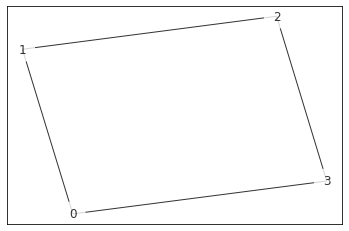

In [349]:
#some fancy graph
#G = nx.Graph([(0,1),(0,2),(0,3),(1,2),(1,3),(0,4),(2,4),(3,4),(2,5),(4,5)])

#nice testing graph
#G = nx.Graph([(0,1),(1,2),(1,3),(0,2),(2,4),(1,4)])

G = nx.Graph([(0,1),(1,2),(2,3),(0,3)])
edges = len(G)
A = nx.adjacency_matrix(G)
A = np.array(A.todense())
print(A)

#mc = maxcut(edges, [[0,1], [1,2], [1,3], [2,3]])
mc = maxcut(G)
mc.draw()
#print(10**(-7))

#mc.build_circuit([1],[1])
#mc.circuit.circ.draw()

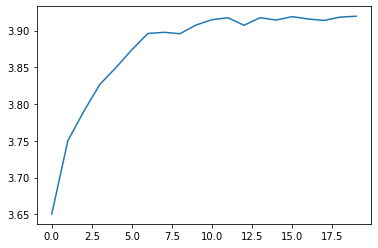

Wall time: 19.3 s


In [341]:
%%time

curve = mc.train(opt_rounds=20, depth = 2, sims = 30000, learning_rate = 0.01)
plt.plot(curve)
plt.show()

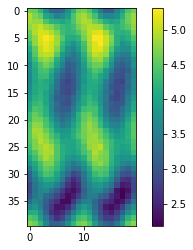

In [30]:
mc.heatmap(1, n_gamma=40, n_beta=20)

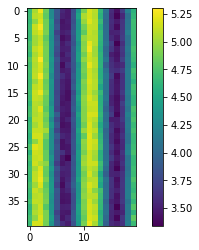

In [31]:
mc.heatmap(2, n_gamma=40, n_beta=20)

Optimal bitstring: [0 1 1 0 0]
Optimal value: 5
Total amount of difft solutions founds 32


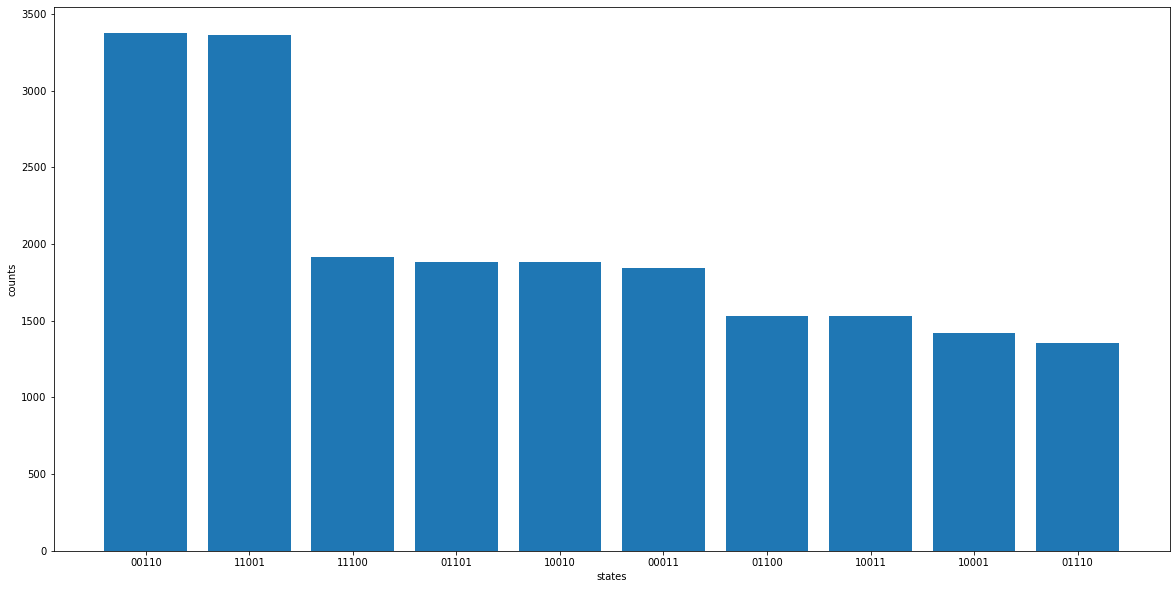

In [342]:
counts = mc.counts


y=0

newcounts = sorted(counts.items(), key = lambda x:(x[1], x[0]), reverse=True)

y = np.array([int(x) for x in list(newcounts[0][0].format(len(newcounts[0][0])))])
y = y[::-1]
print("Optimal bitstring:", y)
print("Optimal value:", int(np.sum(np.outer(y,(1-y)) * A)))
print("Total amount of difft solutions founds", len(counts))




plt.figure(figsize=(20,10))
plt.bar(range(min(len(counts),10)), list(np.array(newcounts)[0:10,1].astype(int)), align='center')
plt.xticks(range(min(len(counts),10)), list(np.array(newcounts)[0:10,0]))
plt.xlabel('states')
plt.ylabel('counts')
plt.show()


In [319]:
print('trained beta:', mc.beta)
print('trained gamma:', mc.gamma)

trained beta: [0.4967 0.3511]
trained gamma: [0.5248 0.4905]


### 

In [350]:
#Thingy for binary thingy
s = list("{0:0eb}")
s[4] = str(edges)
binlist="".join(s)

energy = np.zeros(2**edges, dtype=int)
for k in range(0,2**edges):
    y = np.array([int(x) for x in binlist.format(k)]) #btw we gotta change this part manually when we have larger graph
    energy[k] = int(np.sum(np.outer(y,(1-y)) * A))

energy.sort()
print(energy[::-1])

[4 4 2 2 2 2 2 2 2 2 2 2 2 2 0 0]


In [104]:
#Amount of samples from the grid
ngamma, nbeta = (20,5)

#Which part of the space are we gonna consider.
gmin = [1,0]
gmax = [1,1]
bmin = [0,0]
bmax = [0,1]


#Initializing rando variables
p = 2 #Depth
expectation = np.zeros((ngamma,nbeta))
expectation2 = np.zeros((ngamma,nbeta))
energy = np.zeros(2**edges, dtype=int)
gamma = np.zeros((depth,ngamma))
beta = np.zeros((depth,nbeta))


#Creating the grid
for i in range(0,p):
    gamma[i,:] = np.linspace(gmin[i]*2*pi, gmax[i]*2*pi, ngamma)
    beta[i,:] = np.linspace(bmin[i], bmax[i], nbeta)



#Thingy for binary thingy
s = list("{0:0eb}")
s[4] = str(edges)
binlist="".join(s)


#Amount of simulations
shots = 10000

#Calculating the energies that belong to each state. I think with a real quantum computer we could perhaps skip this.

for k in range(0,2**edges):
    y = np.array([int(x) for x in binlist.format(k)]) #btw we gotta change this part manually when we have larger graph
    energy[k] = int(np.sum(np.outer(y,(1-y)) * A))

#Find the expectation value for each point on the grid
for i in range(0,ngamma):
    for j in range(0,nbeta):
        mc.build_circuit(depth = p, beta = beta[:,j], gamma = gamma[:,i])
        counts = mc.solve(sims=shots)

        #re-ordering
        counts = sorted(counts.items(), key = lambda x:(x[0], x[1]), reverse=True)
        counts2 = np.array(counts).astype(int)[::-1]

        #Sometimes a state gets no count. This is to preserve the dimension of the energy.
        energy2 = np.zeros(len(counts2), dtype=int)

        #Prevent energy and counts2 array not same dimensions coz counts doesn't return no count states
        for k in range(0,len(counts2)):
            energy2[k] = energy[int(str(counts2[k,0]),2)]


        #Fancy expectation
        expectation[i,j] = np.dot(np.array(energy2),counts2[:,1])/shots        


#Fancy expectation heatmap
plt.imshow(expectation);
plt.colorbar()
plt.show()

#Gradient
grad = np.gradient(expectation)
print(grad)

the counts of each states: {'11010': 323, '10101': 313, '01100': 302, '00000': 291, '00011': 318, '11100': 300, '10000': 309, '00111': 316, '11011': 293, '11001': 307, '10010': 321, '01110': 335, '01000': 302, '01001': 280, '01111': 341, '10111': 292, '10110': 368, '00001': 299, '00010': 309, '10011': 289, '10100': 314, '11111': 344, '11000': 317, '01010': 319, '01101': 317, '00101': 330, '11110': 292, '00100': 332, '10001': 312, '01011': 334, '00110': 278, '11101': 303}


AttributeError: 'NoneType' object has no attribute 'items'

In [ ]:
grad = np.gradient(expectation)
plt.imshow(grad[0]);
plt.colorbar()
plt.show()
print(grad)
print(np.amax(abs(grad[0])))
print(np.amax(abs(grad[1])))
print(np.zeros((3,2)*2))

In [232]:
depth = 2

gamma = np.zeros((depth,ngamma))
gmin = [0,2]
gmax = [3,3]

for i in range(0,depth):
    gamma[i,:] = np.linspace(gmin[i], gmax[i], ngamma)
# for j in range(0,nbeta):
#     beta = np.linspace(bmin, bmax/sect, nbeta)
print(gamma)

[[0.         0.15789474 0.31578947 0.47368421 0.63157895 0.78947368
  0.94736842 1.10526316 1.26315789 1.42105263 1.57894737 1.73684211
  1.89473684 2.05263158 2.21052632 2.36842105 2.52631579 2.68421053
  2.84210526 3.        ]
 [2.         2.05263158 2.10526316 2.15789474 2.21052632 2.26315789
  2.31578947 2.36842105 2.42105263 2.47368421 2.52631579 2.57894737
  2.63157895 2.68421053 2.73684211 2.78947368 2.84210526 2.89473684
  2.94736842 3.        ]]


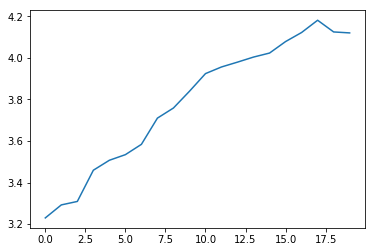

In [188]:
#Initializing rando variables
p = 4 #Depth
expectation = np.zeros(2)
energy = np.zeros(2**edges, dtype=int)
Delta = 0.01


#Thingy for binary thingy
s = list("{0:0eb}")
s[4] = str(edges)
binlist="".join(s)


#Amount of simulations
shots = 3000

#Calculating the energies that belong to each state. I think with a real quantum computer we could perhaps skip this.
for k in range(0,2**edges):
    y = np.array([int(x) for x in binlist.format(k)]) #btw we gotta change this part manually when we have larger graph
    energy[k] = int(np.sum(np.outer(y,(1-y)) * A))

    
    
#intialize beta (x) and gamma(y)
x = np.full(p,.5)
y = np.full(p,.5)
dx = np.zeros(p)
dy = np.zeros(p)

#Gonna use this in the loop
xnew = x
ynew = y

#Optimizer parameters. Correction is the step size we are gonna use for changing x and y
OptiRounds = 20
Expected = np.zeros(OptiRounds)
correction = 0.01


#This part looks super messy. Perhaps we could write a function that outputs the expectation value for given x and y

#This loop is for the optimization. That's why this stuff takes ages to run.
for m in range(0,OptiRounds):
    
    for l in range(0,p):

        #Find the expectation value for each point on the grid for varying beta
        for j in range(0,2):
            xnew = x
            #print(xnew)
            xnew[l] = x[l]+(-1)**j*Delta
            #print(xnew)
            mc.build_circuit(beta = xnew, gamma = y)
            mc.solve(sims=shots)
            counts = mc.counts
            xnew = 0
            #re-ordering
            counts = sorted(counts.items(), key = lambda x:(x[0], x[1]), reverse=True)
            counts2 = np.array(counts).astype(int)[::-1]

            #Sometimes a state gets no count. This is to preserve the dimension of the energy.
            energy2 = np.zeros(len(counts2), dtype=int)

            #Prevent energy and counts2 array not same dimensions coz counts doesn't return no count states
            for k in range(0,len(counts2)):
                energy2[k] = energy[int(str(counts2[k,0]),2)]

            #Fancy expectation
            expectation[j] = np.dot(np.array(energy2),counts2[:,1])/shots  

        #Calculate derivative at beta central difference
        dx = (expectation[0]-expectation[1])/(2*Delta)



        #Find the expectation value for each point on the grid for varying gamma
        for j in range(0,2):
            ynew = y
            ynew[l] = y[l]+(-1)**j*Delta
            mc.build_circuit(beta = x, gamma = ynew)
            mc.solve(sims=shots)
            counts = mc.counts
            ynew = 0
            #re-ordering
            counts = sorted(counts.items(), key = lambda x:(x[0], x[1]), reverse=True)
            counts2 = np.array(counts).astype(int)[::-1]

            #Sometimes a state gets no count. This is to preserve the dimension of the energy.
            energy2 = np.zeros(len(counts2), dtype=int)

            #Prevent energy and counts2 array not same dimensions coz counts doesn't return no count states
            for k in range(0,len(counts2)):
                energy2[k] = energy[int(str(counts2[k,0]),2)]

            #Fancy expectation
            expectation[j] = np.dot(np.array(energy2),counts2[:,1])/shots  

        #Calculate derivative at beta central difference
        dy = (expectation[0]-expectation[1])/(2*Delta)
        
        
        #Apply correction. Notice the + sign coz we have gradient ascent.
        x[l] = x[l]+correction*dx
        y[l] = y[l]+correction*dy






    #Here we output the expectation value for the corrected x and y. Just nice to see how the expectation value increases
    mc.build_circuit(beta = x, gamma = y)
    mc.solve(sims=shots)
    counts = mc.counts
    #re-ordering
    counts = sorted(counts.items(), key = lambda x:(x[0], x[1]), reverse=True)
    counts2 = np.array(counts).astype(int)[::-1]

    #Sometimes a state gets no count. This is to preserve the dimension of the energy.
    energy2 = np.zeros(len(counts2), dtype=int)

    #Prevent energy and counts2 array not same dimensions coz counts doesn't return no count states
    for k in range(0,len(counts2)):
        energy2[k] = energy[int(str(counts2[k,0]),2)]

    #Fancy expectation
    Expected[m] = np.dot(np.array(energy2),counts2[:,1])/shots  
    #print(Expected)
        
        
        
        
        
        
        
        
        
        
        
        
#Fancy expectation heatmap
plt.plot(Expected)
plt.show()

# #Random thingies
# print(expectation)
# print(dx)
# print(x)
# print(y)